In [26]:
%load_ext autoreload
%autoreload 2

from utils import get_eval_stats, analyze_protein_gen_helper, analyze_protein_gen_helper_violin
from collect_experiments import collect_ddg_n10_experiments, collect_ddg_n50_experiments
import seaborn as sn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
def display_experiments(n, oracle, target_protein=None):
    collect_experiments = globals()[f'collect_{oracle}_n{n}_experiments']
    experiments = collect_experiments()
    data = [exp.get_df() for exp in experiments]
    labels = [exp.name for exp in experiments]
    colors = sn.color_palette("Set2", len(experiments))
    protein_output = target_protein + " " if target_protein is not None else ""
    
    if oracle == 'ddg':
        oracle_name = 'ΔΔG'
    elif oracle == 'loglikelihood':
        oracle_name = 'Log Likelihood'
    elif oracle == 'balanced':
        oracle_name = 'Balanced'
    else:
        raise ValueError(f"Unknown oracle: {oracle}")
    analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'ddg_eval', y_label='Predicted ΔΔG', legend_pos='right', title=f'{protein_output}ΔΔG Evaluation: {oracle_name} Alignment (N={n})')
    analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'loglikelihood', y_label='Log Likelihood', legend_pos='right', title=f'{protein_output}Log Likelihood Evaluation: {oracle_name} Alignment (N={n})')

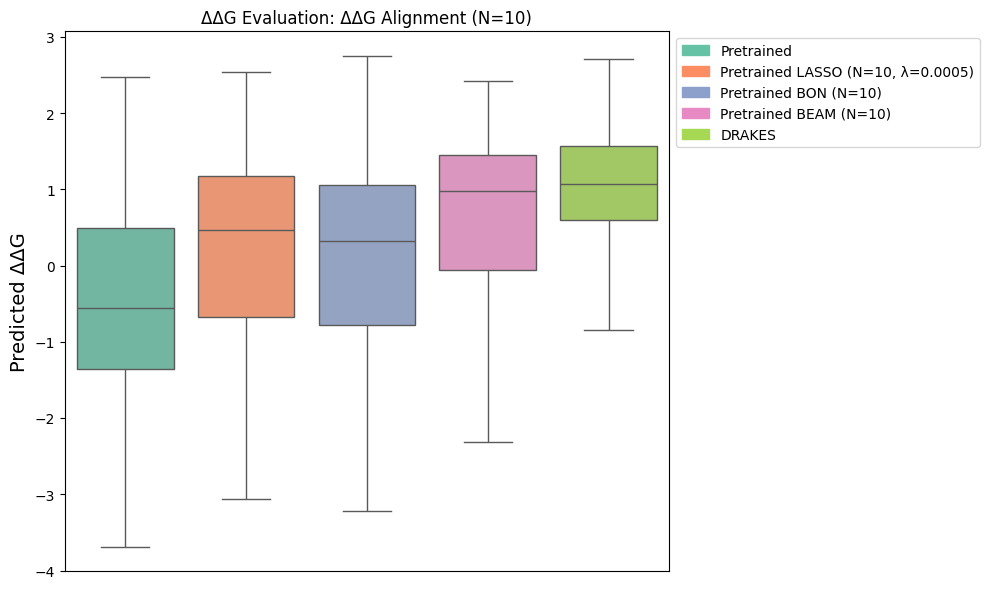

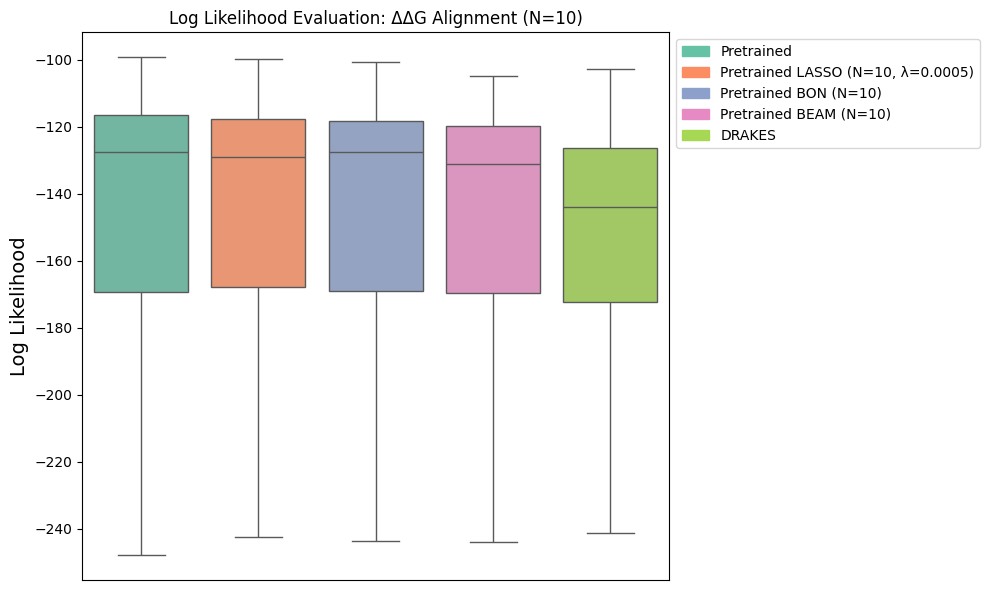

In [34]:
display_experiments(10, 'ddg')